In [52]:
import pandas as pd
df = pd.read_csv('./data/imdb_sup.csv')
df = df.sample(frac=0.1, replace=False, random_state=42)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 33553 to 20382
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     5000 non-null   object
 1   Rating     5000 non-null   int64 
 2   Sentiment  5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 156.2+ KB


,Review,Rating,Sentiment
33553,Having read all of the comments on this film I...,9,1
9427,I like this film a lot. It has a wonderful che...,8,1
199,I am a huge fan of Simon Pegg and have watched...,7,1
12447,This was what black society was like before th...,10,1
39489,pretty disappointing. i was expecting more of ...,3,0


In [53]:
def print_null_and_dups(df):
    print("null values",df.isna().sum())
    print("duplicated values",df.duplicated('Review').sum())
    df[df.duplicated('Review',keep='first')].sort_values('Review').head(10)

In [54]:
df = df.drop_duplicates('Review',keep='first')
print_null_and_dups(df)

null values Review       0
Rating       0
Sentiment    0
dtype: int64
duplicated values 0


In [55]:
#Clean the data
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner', 'textcat'])
#nlp.Defaults.stop_words
def clean_text(text):
    doc = nlp(text)
    
    #Lemmatize and remove stopwords and non-alphabetical characters
    text = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(text)


In [56]:
df['Clean_Review'] = df['Review'].apply(clean_text)
df.head()

,Review,Rating,Sentiment,Clean_Review
33553,Having read all of the comments on this film I...,9,1,have read comment film amazed fox reluctance r...
9427,I like this film a lot. It has a wonderful che...,8,1,like film lot wonderful chemistry actor tell s...
199,I am a huge fan of Simon Pegg and have watched...,7,1,huge fan simon pegg watch plenty movie cease l...
12447,This was what black society was like before th...,10,1,black society like crack epidemic gangsta rap ...
39489,pretty disappointing. i was expecting more of ...,3,0,pretty disappointing expect horror thriller ep...


In [57]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df['Sentiments'] = df['Review'].apply(lambda x: sia.polarity_scores(x))
df = pd.concat([df.drop(['Sentiments'], axis=1), df['Sentiments'].apply(pd.Series)], axis=1)

df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\eklun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Review,Rating,Sentiment,Clean_Review,neg,neu,pos,compound
33553,Having read all of the comments on this film I...,9,1,have read comment film amazed fox reluctance r...,0.035,0.755,0.211,0.9962
9427,I like this film a lot. It has a wonderful che...,8,1,like film lot wonderful chemistry actor tell s...,0.000,0.869,0.131,0.9251
199,I am a huge fan of Simon Pegg and have watched...,7,1,huge fan simon pegg watch plenty movie cease l...,0.028,0.743,0.229,0.9754
12447,This was what black society was like before th...,10,1,black society like crack epidemic gangsta rap ...,0.110,0.827,0.063,-0.7964
39489,pretty disappointing. i was expecting more of ...,3,0,pretty disappointing expect horror thriller ep...,0.041,0.708,0.251,0.8922


In [62]:
# create doc2vec vector columns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['Clean_Review'].apply(lambda x: x.split(' ')))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df['Clean_Review'].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ['doc2vec_vector_' + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)
df.head()

,Review,Rating,Sentiment,Clean_Review,neg,neu,pos,compound,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
33553,Having read all of the comments on this film I...,9,1,have read comment film amazed fox reluctance r...,0.035,0.755,0.211,0.9962,0.645426,2.099808,0.963201,-1.014570,0.670740,1.261933,1.625136,0.968308,-1.257609,0.668107
9427,I like this film a lot. It has a wonderful che...,8,1,like film lot wonderful chemistry actor tell s...,0.000,0.869,0.131,0.9251,-0.072382,0.029193,0.266231,-1.269695,0.380823,-0.148634,-0.170899,0.598288,-1.173189,0.243651
199,I am a huge fan of Simon Pegg and have watched...,7,1,huge fan simon pegg watch plenty movie cease l...,0.028,0.743,0.229,0.9754,0.071714,0.143289,0.210708,-0.666845,0.053996,0.026202,0.165692,0.291700,-0.610695,-0.065308
12447,This was what black society was like before th...,10,1,black society like crack epidemic gangsta rap ...,0.110,0.827,0.063,-0.7964,0.203465,0.458141,0.751971,-0.848361,0.868387,-0.000306,0.391836,0.970596,-0.751153,0.674392
39489,pretty disappointing. i was expecting more of ...,3,0,pretty disappointing expect horror thriller ep...,0.041,0.708,0.251,0.8922,0.132259,0.318954,0.146936,-0.272954,0.021021,0.089082,0.300745,0.221608,-0.251471,0.031899


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df['Clean_Review']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ['word_' + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)
df.head()

,Review,Rating,Sentiment,Clean_Review,neg,neu,pos,compound,doc2vec_vector_0,doc2vec_vector_1,...,word_young,word_youngster,word_youth,word_youthful,word_youtube,word_zany,word_zero,word_zombie,word_zombies,word_zone
33553,Having read all of the comments on this film I...,9,1,have read comment film amazed fox reluctance r...,0.035,0.755,0.211,0.9962,0.645426,2.099808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9427,I like this film a lot. It has a wonderful che...,8,1,like film lot wonderful chemistry actor tell s...,0.000,0.869,0.131,0.9251,-0.072382,0.029193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,I am a huge fan of Simon Pegg and have watched...,7,1,huge fan simon pegg watch plenty movie cease l...,0.028,0.743,0.229,0.9754,0.071714,0.143289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12447,This was what black society was like before th...,10,1,black society like crack epidemic gangsta rap ...,0.110,0.827,0.063,-0.7964,0.203465,0.458141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39489,pretty disappointing. i was expecting more of ...,3,0,pretty disappointing expect horror thriller ep...,0.041,0.708,0.251,0.8922,0.132259,0.318954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df['posneg'] = df['Rating'].apply(lambda x: 0 if x < 5 else 1)
df.head()


,Review,Rating,Sentiment,Clean_Review,neg,neu,pos,compound,doc2vec_vector_0,doc2vec_vector_1,...,word_youngster,word_youth,word_youthful,word_youtube,word_zany,word_zero,word_zombie,word_zombies,word_zone,posneg
33553,Having read all of the comments on this film I...,9,1,have read comment film amazed fox reluctance r...,0.035,0.755,0.211,0.9962,0.645426,2.099808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9427,I like this film a lot. It has a wonderful che...,8,1,like film lot wonderful chemistry actor tell s...,0.000,0.869,0.131,0.9251,-0.072382,0.029193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
199,I am a huge fan of Simon Pegg and have watched...,7,1,huge fan simon pegg watch plenty movie cease l...,0.028,0.743,0.229,0.9754,0.071714,0.143289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
12447,This was what black society was like before th...,10,1,black society like crack epidemic gangsta rap ...,0.110,0.827,0.063,-0.7964,0.203465,0.458141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
39489,pretty disappointing. i was expecting more of ...,3,0,pretty disappointing expect horror thriller ep...,0.041,0.708,0.251,0.8922,0.132259,0.318954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [65]:
top_rev = (df.groupby('Rating') 
            .agg(count=('Rating', 'count'))
            .reset_index()
            .sort_values('Rating',ascending=True)
            )
top_rev

,Rating,count
0,1,1001
1,2,456
2,3,493
3,4,554
4,7,476
5,8,578
6,9,456
7,10,986


In [1]:
df.sort_values('neg', ascending = False)[['Clean_Review','Review', 'neg']].head(1)

NameError: name 'df' is not defined

In [67]:
df_train = df.drop(['Review','Clean_Review','Sentiment'],axis=1)

X = df_train.drop(['posneg'],axis=1)
Y = df_train['posneg']
X

,Rating,neg,neu,pos,compound,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,...,word_young,word_youngster,word_youth,word_youthful,word_youtube,word_zany,word_zero,word_zombie,word_zombies,word_zone
33553,9,0.035,0.755,0.211,0.9962,0.645426,2.099808,0.963201,-1.014570,0.670740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9427,8,0.000,0.869,0.131,0.9251,-0.072382,0.029193,0.266231,-1.269695,0.380823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
199,7,0.028,0.743,0.229,0.9754,0.071714,0.143289,0.210708,-0.666845,0.053996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
12447,10,0.110,0.827,0.063,-0.7964,0.203465,0.458141,0.751971,-0.848361,0.868387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
39489,3,0.041,0.708,0.251,0.8922,0.132259,0.318954,0.146936,-0.272954,0.021021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39885,1,0.155,0.752,0.093,-0.9701,-0.129178,0.158044,1.316577,-1.102362,-0.061334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113769,0.0,0.0
17566,2,0.168,0.727,0.105,-0.7705,0.501042,0.603748,0.008777,-0.653892,-0.067210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
16062,1,0.386,0.614,0.000,-0.8316,0.016788,-0.000611,0.134546,-0.015608,-0.171204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
48445,1,0.048,0.775,0.177,0.9729,0.499978,1.097951,0.310108,-0.808564,0.491024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [68]:
from sklearn.model_selection import train_test_split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, 
                                                    Y, test_size=0.25, 
                                                    random_state=42)

In [69]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_rf, y_train_rf)
preds = model.predict(X_test_rf)

In [70]:
from sklearn.metrics import classification_report
classification_decision1 = (classification_report(y_test_rf, model.predict(X_test_rf)))
print(classification_decision1)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       612
           1       1.00      0.99      1.00       638

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250



In [71]:
from sklearn.linear_model import LogisticRegression
X_train_lr, X_test_lr,y_train_lr,y_test_lr = train_test_split(X,
                                                Y,
                                                test_size = 0.3,
                                                random_state = 42)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_lr, y_train_lr)

LogisticRegression(random_state=42)

In [72]:
classification_decision2 = (classification_report(y_test_lr,logreg.predict(X_test_lr)))
print(classification_decision2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       740
           1       1.00      1.00      1.00       760

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



In [73]:
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
def wordCloud_generator(data, color, color_map):
    wave_mask = np.array(Image.open('cloud.png'))
    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                          mask = wave_mask
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

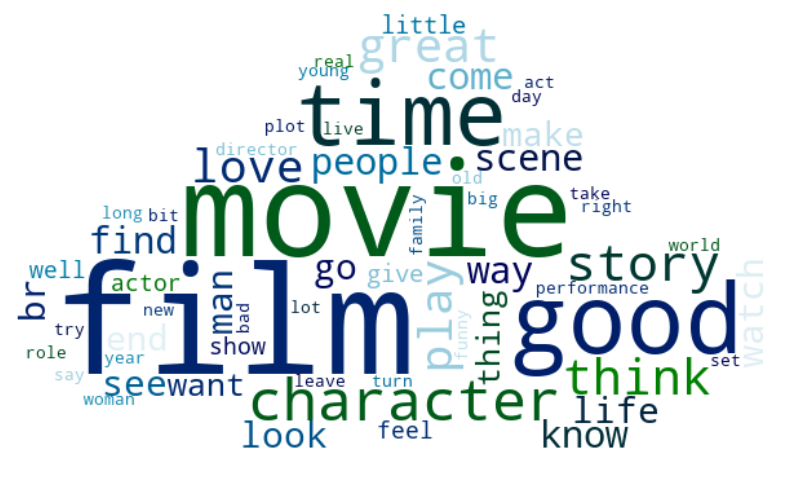

In [74]:
import numpy as np
train_pos = df[ df['posneg'] == 1]
train_pos = train_pos['Clean_Review']

wordCloud_generator(train_pos, 'white', 'ocean')

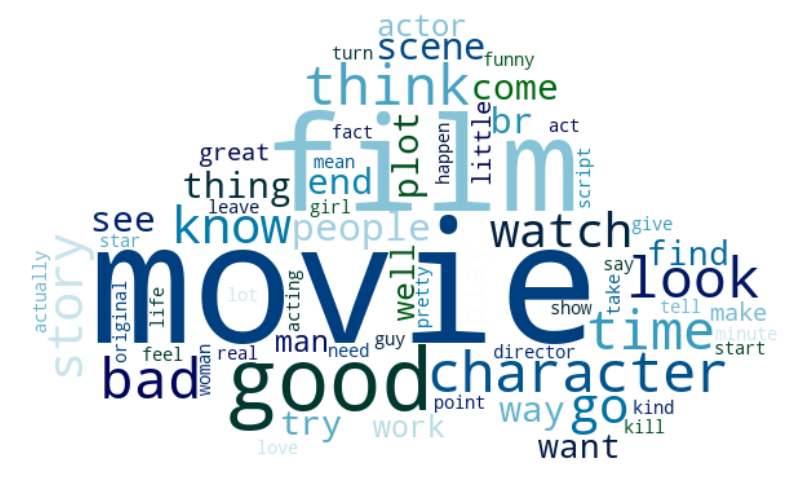

In [75]:
train_neg = df[ df['posneg'] == 0]
train_neg = train_neg['Clean_Review']
wordCloud_generator(train_neg, 'white', 'ocean')
